In [0]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array
from sklearn.cluster import KMeans
#from sklearn.streams.model import MicroCluster as model
from scipy.spatial import distance
import math
import numpy as np
import threading
import time
import sys
import pickle
import matplotlib.pyplot as plt


In [0]:
import math as math
import numpy as np
timeStamp= -1

class MicroCluster:
    """
    Implementation of the MicroCluster data structure for the CluStream algorithm
    Parameters
    ----------
    :parameter nb_points is the number of points in the cluster
    :parameter identifier is the identifier of the cluster (take -1 if the cluster result from merging two clusters)
    :parameter merge is used to indicate whether the cluster is resulting from the merge of two existing ones
    :parameter id_list is the id list of merged clusters
    :parameter linear_sum is the linear sum of the points in the cluster.
    :parameter squared_sum is  the squared sum of all the points added to the cluster.
    :parameter linear_time_sum is  the linear sum of all the timestamps of points added to the cluster.
    :parameter squared_time_sum is  the squared sum of all the timestamps of points added to the cluster.
    :parameter update_timestamp is used to indicate the last update time of the cluster
    """

    def __init__(self, nb_points=0, identifier=0, id_list=None, linear_sum=None,
                 squared_sum=None, linear_time_sum=0, squared_time_sum=0, update_timestamp=0):
        self.nb_points = nb_points
        self.identifier = identifier
        self.id_list = id_list
        self.linear_sum = linear_sum
        self.squared_sum = squared_sum
        self.linear_time_sum = linear_time_sum
        self.squared_time_sum = squared_time_sum
        self.update_timestamp = update_timestamp
        self.min_variance = math.pow(1, -5)

    def __str__(self):
        return  str(self.__class__) + '\n'+ '\n'.join(('{} = {}'.format(item, self.__dict__[item]) for item in self.__dict__))
    def __repr__(self):
        from pprint import pformat
        return "<" + type(self).__name__ + "> " + pformat(vars(self), indent=4, width=1)
        
    def get_center(self):
        center = [self.linear_sum[i] / self.nb_points for i in range(len(self.linear_sum))]
        return center

    def get_weight(self):
        return self.nb_points


    def insert(self, new_point, current_timestamp):
        self.nb_points += 1
        self.update_timestamp = current_timestamp
        for i in range(len(new_point)):
            self.linear_sum[i] += new_point[i]
            self.squared_sum[i] += math.pow(new_point[i], 2)
            self.linear_time_sum += current_timestamp
            self.squared_time_sum += math.pow(current_timestamp, 2)


    def merge(self, micro_cluster):
        ## micro_cluster must be removed
        self.nb_points += micro_cluster.nb_points
        self.linear_sum += micro_cluster.linear_sum
        self.squared_sum += micro_cluster.squared_sum
        self.linear_time_sum += micro_cluster.linear_time_sum
        self.squared_time_sum += micro_cluster.squared_time_sum

        if (self.identifier != -1):
            if (micro_cluster.identifier != -1):
                self.id_list = [self.identifier, micro_cluster.identifier]
            else:
                micro_cluster.id_list.append(self.identifier)
                self.id_list = micro_cluster.id_list.copy()
            self.identifier = -1
        else :
            if (micro_cluster.identifier != -1):
                self.id_list.append(micro_cluster.identifier)
            else:
                self.id_list.extend(micro_cluster.id_list)

    def get_mutime(self):
        return self.linear_time_sum / self.nb_points

    def get_sigmatime(self):
        return math.sqrt(self.squared_time_sum / self.nb_points - math.pow((self.linear_time_sum / self.nb_points), 2))

    def get_quantile(self, x):
        assert(x >= 0 and x <= 1)
        return math.sqrt(2) * self.inverse_error(2 * x - 1)

    def get_clsuter_feature(self):
        return self.this

    def get_deviation(self):
        variance = self.get_variance_vec()
        sum_deviation = 0
        for i in range(len(variance)):
            sqrt_deviation = math.sqrt(variance[i])
            sum_deviation += sqrt_deviation
        return sum_deviation / len(variance)

    def get_variance_vec(self):
        variance_vec = list()
        for i in range(len(self.linear_sum)):
            ls_mean = self.linear_sum[i] / self.nb_points
            ss_mean = self.squared_sum[i] / self.nb_points
            variance = ss_mean - math.pow(ls_mean, 2)
            if variance <= 0:
                if variance > - self.epsilon:
                    variance = self.min_variance

            variance_vec.append(variance)
        return variance_vec

    def inverse_error(self, x):
        z = (math.sqrt(math.pi) * x)
        inv_error = z / 2
        z_prod = math.pow(z,3)
        inv_error += (1 / 24) * z_prod

        z_prod *= math.pow(z,2)
        inv_error += (7 / 960) * z_prod

        z_prod = math.pow(z,2)
        inv_error += (127 * z_prod) / 80640

        z_prod = math.pow(z,2)
        inv_error += (4369 / z_prod) * 11612160

        z_prod = math.pow(z,2)
        inv_error += (34807 / z_prod) * 364953600

        z_prod = math.pow(z,2)
        inv_error += (20036983 / z_prod) * 0x797058662400d
        return z_prod

In [0]:
class CluStream(BaseEstimator, ClusterMixin):
    #Implementation of CluStream
    #
    def __init__(self,  nb_initial_points=10, time_window=1, timestamp=0, clocktime=0, nb_micro_cluster=100,
                nb_macro_cluster=5, micro_clusters=[], alpha=2, l=2 , h=100):
        self.nb_initial_points = nb_initial_points
        self.time_window = time_window  # Range of the window
        self.timestamp = timestamp
        self.clocktime = clocktime
        self.micro_clusters = micro_clusters
        self.nb_micro_cluster = nb_micro_cluster
        self.nb_macro_cluster = nb_macro_cluster
        self.alpha = alpha
        self.l = l
        self.h = h
        self.snapshots = []
        self.weights = []
        self.nb_created_clusters = 0
        self.kmeans = KMeans(n_clusters=self.nb_micro_cluster, random_state=1)

    def fit(self, X, Y=None):
        global timeStamp
        timeStamp += 1
        X = check_array(X, accept_sparse='csr')
        nb_initial_points = X.shape[0]
        if nb_initial_points >= self.nb_initial_points:
            micro_cluster_labels = self.kmeans.fit_predict(X, Y)
            X = np.column_stack((micro_cluster_labels, X))
            initial_clusters = [X[X[:, 0] == h][:, 1:] for h in set(micro_cluster_labels) if h != -1]

            plt.scatter(X[:, 0], X[:, 1], c=micro_cluster_labels, s=50, cmap='viridis')
            centers = self.kmeans.cluster_centers_
            plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

            for cluster in initial_clusters:
                self.create_micro_cluster(cluster,timeStamp)
        self.start_time = timeStamp

    def create_micro_cluster(self, cluster,timeStampDef=None):
        global timeStamp
        linear_sum = np.zeros(cluster.shape[1])
        squared_sum = np.zeros(cluster.shape[1])
        self.nb_created_clusters += 1
        new_m_cluster = MicroCluster(identifier=self.nb_created_clusters, nb_points=0, linear_sum=linear_sum,
                                        squared_sum=squared_sum, update_timestamp=0)
        update_timestamp = timeStampDef
        if(timeStampDef==None):
          timeStamp += 1        
          update_timestamp = timeStamp
        for point in cluster:
            new_m_cluster.insert(point, update_timestamp)
            print("In create.............%d",update_timestamp)
        self.micro_clusters.append(new_m_cluster)

    
    def snapshots_taking(self):
        global timeStamp
        # take a snapshot at each second
        threading.Timer(1.0, self.snapshots_taking).start()
        clock_time = int(timeStamp)
        print(str(clock_time))
        #snapshot = open(str(clock_time) + ".txt", "w")
        with open(str(clock_time) + ".txt", "wb") as snapshot_write_file:
          pickle.dump(self.micro_clusters, snapshot_write_file)
        #snapshot.write(str(self.micro_clusters))
        #snapshot.close()

    def snapshot_manager(self):
        # check the number of snapshot per order
        # check if the time of snapshot is redundant
        # delete the convienient snapshot
        max_order = math.pow(self.alpha, self.l) + 1
        print("111111111111",max_order)
        nbr_orders = int(max_order + 1)
        print("22222222",nbr_orders)
        nbr_snapshot_order = np.zeros(int(nbr_orders))
        

    def distance_to_cluster(self, x, cluster):
        return distance.euclidean(x, cluster.get_center())

    def find_closest_cluster(self, x, micro_clusters):
        min_distance = sys.float_info.max
        for cluster in micro_clusters:
            distance_cluster = self.distance_to_cluster(x, cluster)
            if distance_cluster < min_distance:
                min_distance = distance_cluster
                closest_cluster = cluster
        return closest_cluster

    def check_fit_in_cluster(self, x, cluster):
        if cluster.get_weight() == 1:
            # determine radius using next closest micro-cluster
            radius = sys.float_info.max
            micro_clusters = self.micro_clusters.copy()
            micro_clusters.remove(cluster)
            next_cluster = self.find_closest_cluster(x, micro_clusters)
            dist = distance.euclidean(next_cluster.get_center(), cluster.get_center())
            radius = min(dist, radius)
        else:
            radius = cluster.get_radius()
        if self.distance_to_cluster(x, cluster) < radius:
            return True
        else:
            return False

    def oldest_updated_cluster(self):
        threshold = self.timestamp - self.time_window
        min_relevance_stamp = sys.float_info.max
        oldest_cluster = None
        for cluster in self.micro_clusters:
            relevance_stamp = cluster.get_relevancestamp()
            if (relevance_stamp < threshold) and (relevance_stamp < min_relevance_stamp):
                min_relevance_stamp = relevance_stamp
                oldest_cluster = cluster
        return oldest_cluster

    def merge_closest_clusters(self):
        min_distance = sys.float_info.max
        for i, cluster in enumerate(self.micro_clusters):
            center = cluster.get_center()
            for next_cluster in self.micro_clusters[i+1:]:
                dist = distance.euclidean(center, next_cluster.get_center())
                if dist < min_distance:
                    min_distance = dist
                    cluster_1 = cluster
                    cluster_2 = next_cluster
        assert (cluster_1 != cluster_2)
        cluster_1.merge(cluster_2)
        self.micro_clusters.remove(cluster_2)

    def partial_fit(self, x, y):
        self.timestamp += 1
        X = x
        x = x[0]
        closest_cluster = self.find_closest_cluster(x, self.micro_clusters)
        check = self.check_fit_in_cluster(x, closest_cluster)
        if check:
            closest_cluster.insert(x, self.start_time-time.time())
        else:
            old_up_clust = self.oldest_updated_cluster()
            if old_up_clust is not None:
                self.micro_clusters.remove(old_up_clust)
            else:
                self.merge_closest_clusters()
            self.create_micro_cluster(X)


    def predict(self, Xin):
        """Predict the class labels for the provided data
        Parameters
        ----------
        X :
        Returns
        -------
        y :"""
        cluster_centers = list(map((lambda i: i.get_center()), self.micro_clusters))
        #centers_weights = list(map((lambda i: i.get_weight()), self.micro_clusters))
        result = self.kmeans.fit_predict(X=cluster_centers, y=None)
        return result

In [4]:
cluster1 = CluStream(nb_initial_points=0, time_window=100, timestamp=0, clocktime=0, nb_micro_cluster=4,
                nb_macro_cluster=5, micro_clusters=[], alpha=2, l=2,h=100)

'''
cluster2 = np.array([[1,2,3],[4,5,6],[7,8,9]])
cluster1.create_micro_cluster(cluster2)
#first make the micro-clusters
time.sleep(3)
cluster3 = np.array([[2,2,2],[3,5,3],[4,8,4]])
cluster1.create_micro_cluster(cluster3)
cluster1'''

'\ncluster2 = np.array([[1,2,3],[4,5,6],[7,8,9]])\ncluster1.create_micro_cluster(cluster2)\n#first make the micro-clusters\ntime.sleep(3)\ncluster3 = np.array([[2,2,2],[3,5,3],[4,8,4]])\ncluster1.create_micro_cluster(cluster3)\ncluster1'

In [5]:
'''def mygenratorfunc():
    c = 10
    i = np.array([[c,c],[-c,-c],[-c,c],[c,-c]])
    for num in range(4):
        cluster = np.random.normal(loc = 0, scale = 2, size = (50,2))
        cluster = [x + i[num] for x in cluster] 
        time.sleep(np.random.randint(5))
        yield cluster
i = 0
cluster2 = np.array([[0,0]])
for clus in mygenratorfunc():
    print(clus[:5])
    cluster2 = np.append(cluster2,clus,axis=0)
    cluster1.fit(clus,i)
    i+=1'''

'def mygenratorfunc():\n    c = 10\n    i = np.array([[c,c],[-c,-c],[-c,c],[c,-c]])\n    for num in range(4):\n        cluster = np.random.normal(loc = 0, scale = 2, size = (50,2))\n        cluster = [x + i[num] for x in cluster] \n        time.sleep(np.random.randint(5))\n        yield cluster\ni = 0\ncluster2 = np.array([[0,0]])\nfor clus in mygenratorfunc():\n    print(clus[:5])\n    cluster2 = np.append(cluster2,clus,axis=0)\n    cluster1.fit(clus,i)\n    i+=1'

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


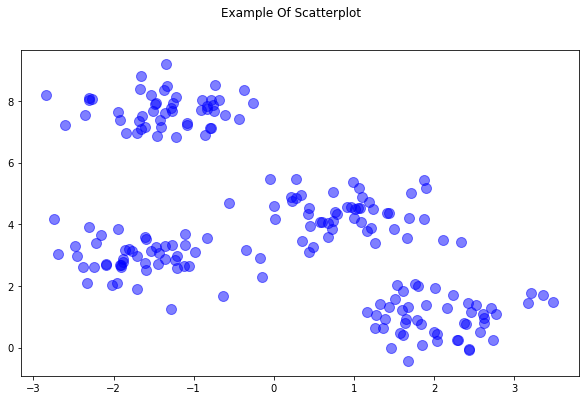

In [6]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=200, centers=4,
                       cluster_std=0.60, random_state=0)


fig, ax = plt.subplots(1, figsize=(10, 6))
fig.suptitle('Example Of Scatterplot')

# Create the Scatter Plot
ax.scatter(X[:,0], X[:,1],
            color="blue",    # Color of the dots
            s=100,           # Size of the dots
            alpha=0.5,       # Alpha/transparency of the dots (1 is opaque, 0 is transparent)
            linewidths=1)    # Size of edge around the dots

# Show the plot
plt.show()


In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
In create.............%d 0
I

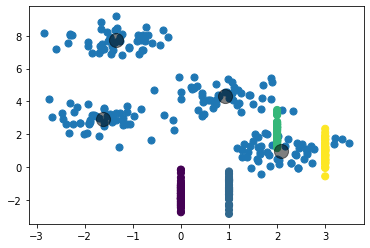

In [7]:
plt.scatter(X[:, 0], X[:, 1], s=50);
cluster1.fit(X,y_true)

In [8]:
for i in cluster1.micro_clusters:
  print(i.nb_points)
  print(i.squared_sum)
  print(i.linear_time_sum)
  print(i.squared_time_sum)
  print(i.update_timestamp)

50
[149.55640867 441.0997085 ]
0
0.0
0
50
[ 107.49571624 2994.35297846]
0
0.0
0
50
[231.34684467  66.19449264]
0
0.0
0
50
[ 59.44253215 967.03538354]
0
0.0
0


In [9]:
cluster1.snapshot_manager()
print(cluster1.micro_clusters)


111111111111 5.0
22222222 6
[<MicroCluster> {   'id_list': None,
    'identifier': 1,
    'linear_sum': array([-81.20070748, 145.79814513]),
    'linear_time_sum': 0,
    'min_variance': 1.0,
    'nb_points': 50,
    'squared_sum': array([149.55640867, 441.0997085 ]),
    'squared_time_sum': 0.0,
    'update_timestamp': 0}, <MicroCluster> {   'id_list': None,
    'identifier': 2,
    'linear_sum': array([-67.42135747, 386.04827408]),
    'linear_time_sum': 0,
    'min_variance': 1.0,
    'nb_points': 50,
    'squared_sum': array([ 107.49571624, 2994.35297846]),
    'squared_time_sum': 0.0,
    'update_timestamp': 0}, <MicroCluster> {   'id_list': None,
    'identifier': 3,
    'linear_sum': array([103.59394617,  48.7114632 ]),
    'linear_time_sum': 0,
    'min_variance': 1.0,
    'nb_points': 50,
    'squared_sum': array([231.34684467,  66.19449264]),
    'squared_time_sum': 0.0,
    'update_timestamp': 0}, <MicroCluster> {   'id_list': None,
    'identifier': 4,
    'linear_sum': arr

In [10]:
cluster1.snapshots_taking()

0


In [11]:
'''with open('4.txt', 'rb') as snapshot_read_file:
    snapshot = pickle.load(snapshot_read_file)
    print(snapshot)'''

"with open('4.txt', 'rb') as snapshot_read_file:\n    snapshot = pickle.load(snapshot_read_file)\n    print(snapshot)"

In [12]:
'''timeStamp
b=5
print(cluster1.predict(np.array([[-b,-b]])))
print(cluster1.predict(np.array([[b,-b]])))
print(cluster1.predict(np.array([[-b,b]])))
print(cluster1.predict(np.array([[b,b]])))'''
def mygenratorfunc():
    c = 10
    i = np.array([[c,c],[-c,-c],[-c,c],[c,-c]])
    for num in range(4):
        cluster = np.random.normal(loc = 0, scale = 2, size = (5,2))
        cluster = [x + i[num] for x in cluster] 
        time.sleep(np.random.randint(5))
        yield cluster
i = 0
cluster2 = np.array([[0,0]])
for clus in mygenratorfunc():
    print(clus)
    cluster2 = np.append(cluster2,clus,axis=0)
    i+=1

print(cluster1.predict(cluster2))

[array([12.05122165, 10.35231787]), array([ 6.98052538, 11.38503474]), array([11.39748376,  9.80641506]), array([11.58318896,  8.74571703]), array([12.29536764,  9.93277622])]
0
0
0
[array([-9.66741584, -8.42429706]), array([ -8.5651371 , -13.70186649]), array([-13.30571043, -11.71082694]), array([-12.79835734,  -8.13367294]), array([ -9.92956726, -10.99640035])]
[array([-11.58580441,   7.954495  ]), array([-5.27129324,  8.58306612]), array([-8.68459399,  9.65115576]), array([-10.0486055 ,   8.78468796]), array([-7.80683781,  6.05879465])]
0
0
0
0
[array([ 10.73209677, -10.94124838]), array([10.82593488, -7.48967413]), array([11.66417096, -6.0143374 ]), array([ 10.36860306, -10.63718329]), array([10.17176247, -9.53254915])]
[0 1 2 3]


In [13]:
b=5
print(cluster1.predict(np.array([[-b,-b],[b,-b],[-b,b],[b,b]]).reshape(-1,2)))


[0 1 2 3]
